## Анализ данных в задаче кредитного скоринга

Для выполнения этого задания вам понадобятся данные о кредитных историях клиентов одного из банков. Поля в предоставляемых данных имеют следующий смысл:

* LIMIT_BAL: размер кредитного лимита (в том числе и на семью клиента)

* SEX: пол клиента (1 = мужской, 2 = женский )

* EDUCATION: образование (0 = доктор, 1 = магистр; 2 = бакалавр; 3 = выпускник школы; 4 = начальное образование; 5= прочее; 6 = нет данных ).

* MARRIAGE: (0 = отказываюсь отвечать; 1 = замужем/женат; 2 = холост; 3 = нет данных).

* AGE: возраст в годах

* PAY_0 - PAY_6 : История прошлых платежей по кредиту. PAY_6 - платеж в апреле, ... Pay_0 - платеж в сентябре. Платеж = (0 = исправный платеж, 1=задержка в один месяц, 2=задержка в 2 месяца ...)

* BILL_AMT1 - BILL_AMT6: задолженность, BILL_AMT6 - на апрель, BILL_AMT1 - на сентябрь

* PAY_AMT1 - PAY_AMT6: сумма уплаченная в PAY_AMT6 - апреле, ..., PAY_AMT1 - сентябре

* default - индикатор невозврата денежных средств

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from statsmodels.iolib.table import SimpleTable
import scipy
%matplotlib inline

In [2]:
data = pd.read_csv('credit_card_default_analysis.csv', sep=',')
data.head()

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default
0,1,20000,2,2,1,24,2,2,0,0,...,0,0,0,0,689,0,0,0,0,1
1,2,120000,2,2,2,26,0,2,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,3,90000,2,2,2,34,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,4,50000,2,2,1,37,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,5,50000,1,2,1,57,0,0,0,0,...,20940,19146,19131,2000,36681,10000,9000,689,679,0


In [3]:
data = data[['LIMIT_BAL', 'SEX', 'EDUCATION', 'MARRIAGE', 'AGE', 'default']]
data.describe()

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,default
count,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000
mean,167484.322667,1.603733,1.853133,1.551867,35.485500,0.221200
std,129747.661567,0.489129,0.790349,0.521970,9.217904,0.415062
min,10000.000000,1.000000,0.000000,0.000000,21.000000,0.000000
25%,50000.000000,1.000000,1.000000,1.000000,28.000000,0.000000
50%,140000.000000,2.000000,2.000000,2.000000,34.000000,0.000000
75%,240000.000000,2.000000,2.000000,2.000000,41.000000,0.000000
max,1000000.000000,2.000000,6.000000,3.000000,79.000000,1.000000


In [4]:
data.default.value_counts()

0    23364
1     6636
Name: default, dtype: int64

In [5]:
data_payment = data[data.default == 0]
data_nonpayment = data[data.default == 1]

### Пункт 1

Размер кредитного лимита (LIMIT_BAL). В двух группах, тех людей, кто вернул кредит (default = 0) и тех, кто его не вернул (default = 1) проверьте гипотезы: a) о равенстве медианных значений кредитного лимита с помощью подходящей интервальной оценки b) о равенстве распределений с помощью одного из подходящих непараметрических критериев проверки равенства средних. Значимы ли полученные результаты с практической точки зрения ?

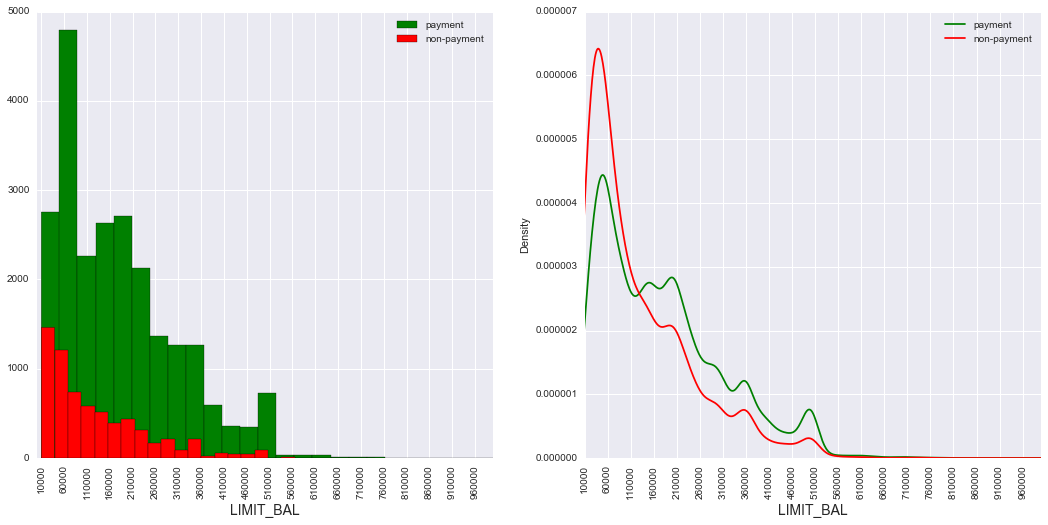

In [6]:
plt.figure(figsize = (18, 8))
plt.subplot(1, 2, 1)
plt.hist(data_payment.LIMIT_BAL, color='g', bins=25, label='payment')
plt.hist(data_nonpayment.LIMIT_BAL, color='r', bins=25, label='non-payment')
plt.legend()
plt.xlabel('LIMIT_BAL', fontsize = 14)
plt.xticks(xrange(data.LIMIT_BAL.min(), data.LIMIT_BAL.max(), 50000), rotation='vertical')

plt.subplot(1, 2, 2)
data_payment.LIMIT_BAL.plot(kind='density', color='g', label='payment')
data_nonpayment.LIMIT_BAL.plot(kind='density', color='r', label='non-payment')
plt.legend()
plt.xlabel('LIMIT_BAL', fontsize = 14)
plt.xticks(xrange(data.LIMIT_BAL.min(), data.LIMIT_BAL.max(), 50000), rotation='vertical')
plt.xlim(data.LIMIT_BAL.min(), data.LIMIT_BAL.max())
plt.show()

По графику видно, что распределения размера кредитного лимита несимметричные, скошенные. Распределение людей, вернувших долг, имеет более тяжелый правый хвост. Скорее всего кредитный лимит среди невыплативших людей лимит меньше, чем у людей, которые вернули кредит. 

a) Проверим равенство медианных значений кредитного лимита с помощью бутстрепа. 

In [7]:
def get_bootstrap_samples(data, n_samples):
    indices = np.random.randint(0, len(data), (n_samples, len(data)))
    samples = data[indices]
    return samples

In [8]:
def stat_intervals(stat, alpha):
    boundaries = np.percentile(stat, [100 * alpha / 2., 100 * (1 - alpha / 2.)])
    return boundaries

In [9]:
payment_median_scores = map(np.median, get_bootstrap_samples(data_payment.LIMIT_BAL.values, 1000))
non_payment_median_scores = map(np.median, get_bootstrap_samples(data_nonpayment.LIMIT_BAL.values, 1000))

Интервальные оценки медиан:

In [10]:
print "95% confidence interval for the LIMIT_BAL (default = 0) median:",  stat_intervals(payment_median_scores, 0.05)
print "95% confidence interval for the LIMIT_BAL (default = 1) median:",  stat_intervals(non_payment_median_scores, 0.05)

95% confidence interval for the LIMIT_BAL (default = 0) median: [ 150000.  150000.]
95% confidence interval for the LIMIT_BAL (default = 1) median: [ 80000.  90000.]


Интервальная оценка разности медиан:

In [11]:
delta_median_scores = np.array(payment_median_scores) - np.array(non_payment_median_scores)
print "95% confidence interval for the difference between LIMIT_BAL medians:",  stat_intervals(delta_median_scores, 0.05)

95% confidence interval for the difference between LIMIT_BAL medians: [ 60000.  70000.]


Интервальные оценки медиан не пересекаются, кроме того интервальная оценка для разности медиан не содержит нуля. Таким образом медианы для двух выборок выплативших и неплативших долг отличаются: для первой выборки она больше. 

Отличие в 60000-70000 единиц скорее всего имеет практическое значение. 

b) Проверим гипотезу о равенстве распределений с помощью непараметрического перестановочного критерия для двух выборок. 

$H_0\colon F_{X_1}(x) = F_{X_2}(x)$

$H_1\colon F_{X_1}(x) = F_{X_2}(x + \Delta), \Delta\neq 0$ - если справедлива альтернативная гипотеза и между распределениями есть сдвиг, то средние значения выборок будут отличаться.

Наши выборки независимые. 

In [12]:
# T-статистика
def permutation_t_stat_ind(sample1, sample2):
    return np.mean(sample1) - np.mean(sample2)

In [13]:
def get_random_combinations(n1, n2, max_combinations):
    index = range(n1 + n2)
    indices = set([tuple(index)])
    for i in range(max_combinations - 1):
        np.random.shuffle(index)
        indices.add(tuple(index))
    return [(index[:n1], index[n1:]) for index in indices]

In [14]:
# Нулевое распределение
def permutation_zero_dist_ind(sample1, sample2, max_combinations = None):
    joined_sample = np.hstack((sample1, sample2))
    n1 = len(sample1)
    n = len(joined_sample)
    
    if max_combinations:
        indices = get_random_combinations(n1, len(sample2), max_combinations)
    else:
        indices = [(list(index), filter(lambda i: i not in index, range(n))) \
                    for index in itertools.combinations(range(n), n1)]
    
    distr = [joined_sample[list(i[0])].mean() - joined_sample[list(i[1])].mean() \
             for i in indices]
    return distr

In [15]:
# p-value
def permutation_test(sample1, sample2, max_permutations = None, alternative = 'two-sided'):
    if alternative not in ('two-sided', 'less', 'greater'):
        raise ValueError("alternative not recognized\n"
                         "should be 'two-sided', 'less' or 'greater'")
    
    t_stat = permutation_t_stat_ind(sample1, sample2)
    
    zero_distr = permutation_zero_dist_ind(sample1, sample2, max_permutations)
    
    if alternative == 'two-sided':
        return sum([1. if abs(x) >= abs(t_stat) else 0. for x in zero_distr]) / len(zero_distr)
    
    if alternative == 'less':
        return sum([1. if x <= t_stat else 0. for x in zero_distr]) / len(zero_distr)

    if alternative == 'greater':
        return sum([1. if x >= t_stat else 0. for x in zero_distr]) / len(zero_distr)

In [16]:
print "p-value: %f" % permutation_test(data_payment.LIMIT_BAL.values, data_nonpayment.LIMIT_BAL.values, max_permutations=10000)

p-value: 0.000100


Таким образом, нулевая гипотеза о равенстве средних отвергается на уровне значимости $\alpha = 0.05$ и распределения статистически значимо различаются. 

### Пункт 2

Пол (SEX): Проверьте гипотезу о том, что гендерный состав группы людей вернувших и не вернувших кредит отличается. Хорошо, если вы предоставите несколько различных решений этой задачи (с помощью доверительного интервала и подходящего статистического критерия)

In [17]:
data_man = data[data.SEX == 1]
data_woman = data[data.SEX == 2]

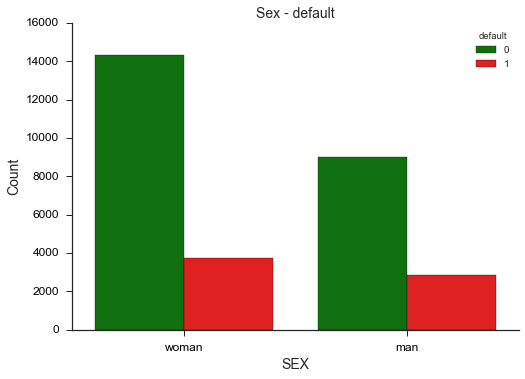

In [18]:
sns.set(style='ticks')

g = sns.countplot(x=['man' if x == 1 else 'woman' for x in data.SEX], hue=data.default, 
                  palette = sns.color_palette(['g', 'r']))

sns.despine()
g.axes.set_title('Sex - default', fontsize=14)
g.set_xlabel('SEX', size=14)
g.set_ylabel('Count', size=14)
g.tick_params(labelsize=12, labelcolor='black')

Судя по графику, среди невыплативших доля женщин и мужчин отличается незначительно, в то время как среди выплативших кредит доля женщин больше. 

Построим таблицу сопряженности для пола и признаком дефолта. 

In [19]:
man0, man1 = len(data_man[data_man.default == 0]), len(data_man[data_man.default == 1])
woman0, woman1 = len(data_woman[data_woman.default == 0]), len(data_woman[data_woman.default == 1])
n1 = man0 + woman0
n2 = man1 + woman1

SimpleTable(([man0, woman0], 
             [man1, woman1]), 
             headers=['man', 'woman'], stubs=['payment', 'non-payment'])

,man,woman
payment,9015,14349
non-payment,2873,3763


$H_0\colon$ Доли невернувших кредит среди мужчин и женщин не отличаются

$H_1\colon$ отличаются (двухсторонняя альтернатива)

**1 вариант:** Построим доверительный интервал для разности долей должников в двух выборках. 

Распределения выборок бинарные, выборки независимые. 

In [20]:
# Доверительный интервал
def proportions_diff_confint_ind(sample1, sample2, label, alpha = 0.05):    
    z = scipy.stats.norm.ppf(1 - alpha / 2.)
    
    p1 = float(len(sample1[sample1 == label])) / len(sample1)
    p2 = float(len(sample2[sample2 == label])) / len(sample2)
    
    left_boundary = (p1 - p2) - z * np.sqrt(p1 * (1 - p1)/ len(sample1) + p2 * (1 - p2)/ len(sample2))
    right_boundary = (p1 - p2) + z * np.sqrt(p1 * (1 - p1)/ len(sample1) + p2 * (1 - p2)/ len(sample2))
    
    return (left_boundary, right_boundary)

In [21]:
print "95%% confidence interval for a difference between proportions in the SEX variable: [%f, %f]" %\
    proportions_diff_confint_ind(data_man.default, data_woman.default, label=1, alpha=0.05)

95% confidence interval for a difference between proportions in the SEX variable: [0.024207, 0.043612]


Полученный доверительный интервал лежит правее нуля, таким образом, на уровне значимости $\alpha = 0.05$ нулевая гипотеза отвергается. Доля должников среди мужчин больше. 

**2 вариант:** Для проверки также будем использовать Z-критерий для доли для двух независимых выборок. 

Наши выборки из распределения Бернулли и независимые. 

In [22]:
# Статистика
def proportions_diff_z_stat_ind(sample1, sample2, label):
    n1 = len(sample1)
    n2 = len(sample2)
    
    p1 = float(len(sample1[sample1 == label])) / n1
    p2 = float(len(sample2[sample2 == label])) / n2 
    P = float(p1*n1 + p2*n2) / (n1 + n2)
    
    return (p1 - p2) / np.sqrt(P * (1 - P) * (1. / n1 + 1. / n2))

In [23]:
# P-value
def proportions_diff_z_test(z_stat, alternative = 'two-sided'):
    if alternative not in ('two-sided', 'less', 'greater'):
        raise ValueError("alternative not recognized\n"
                         "should be 'two-sided', 'less' or 'greater'")
    
    if alternative == 'two-sided':
        return 2 * (1 - scipy.stats.norm.cdf(np.abs(z_stat)))
    
    if alternative == 'less':
        return scipy.stats.norm.cdf(z_stat)

    if alternative == 'greater':
        return 1 - scipy.stats.norm.cdf(z_stat)

In [24]:
z_stat = proportions_diff_z_stat_ind(data_man.default, data_woman.default, label = 1)
p_value = proportions_diff_z_test(z_stat)

print "z-stat: ", z_stat
print "p-value: ", p_value

z-stat:  6.92137508856
p-value:  4.47286652161e-12


Значение p-value меньше 0.05, значит можно снова уверенно отклонить нулевую гипотезу.

### Пункт 3

Образование (EDUCATION): Проверьте гипотезу о том, что образование не влияет на то, вернет ли человек долг. Предложите способ наглядного представления разницы в ожидаемых и наблюдаемых значениях количества человек вернувших и не вернувших долг. Например, составьте таблицу сопряженности "образование" на "возврат долга", где значением ячейки была бы разность между наблюдаемым и ожидаемым количеством человек. Как бы вы предложили модифицировать таблицу так, чтобы привести значения ячеек к одному масштабу не потеряв в интерпретируемости ? Наличие какого образования является наилучшим индикатором того, что человек отдаст долг ? наоборт, не отдаст долг ?

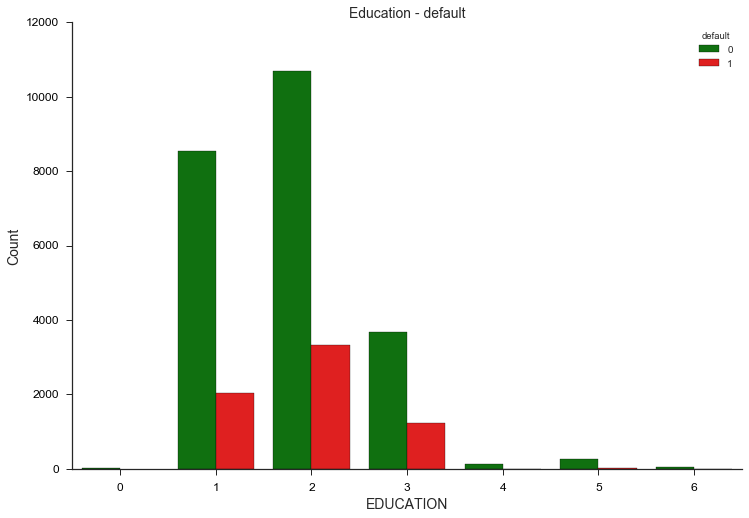

In [25]:
sns.set(style='ticks')

g = sns.countplot(x=data.EDUCATION, hue=data.default, palette = sns.color_palette(['g', 'r']))
sns.despine()
g.figure.set_size_inches(12,8)
g.axes.set_title('Education - default', fontsize=14)
g.set_xlabel('EDUCATION', size=14)
g.set_ylabel('Count', size=14)
g.tick_params(labelsize=12, labelcolor='black')

Будем анализировать влияние переменной EDUCATION на фактор дефолта с помощью критерия Пирсона. С помощью этого метода оценим статистическую значимость различий двух показателей.

Составим таблицу сопряженности для категориальных признаков EDUCATION и default.

In [26]:
observed_payment = np.bincount(data_payment.EDUCATION)
observed_nonpayment = np.bincount(data_nonpayment.EDUCATION)
observed_frequences = np.vstack((observed_payment, observed_nonpayment))

In [27]:
chi2, p, ddof, expected_frequences = stats.chi2_contingency(observed_frequences, correction=False)

Таблица сопряженности "EDUCATION" на "default" для наблюдаемых частот: 

In [28]:
SimpleTable((observed_frequences[0, :], observed_frequences[1, :]), 
             headers = ["Doctor", "Master", "Bachelor", "School grade"," Elementary", "Other", "NA"], 
             stubs=['payment', 'non-payment'], 
             title = 'Contingency table, observed frequences')

,Doctor,Master,Bachelor,School grade,Elementary,Other,NA
payment,14,8549,10700,3680,116,262,43
non-payment,0,2036,3330,1237,7,18,8


Таблица сопряженности "EDUCATION" на "default" для ожидаемых частот: 

In [29]:
SimpleTable((expected_frequences[0, :], expected_frequences[1, :]), 
             headers = ["Doctor", "Master", "Bachelor", "School grade"," Elementary", "Other", "NA"], 
             stubs=['payment', 'non-payment'], 
             title = 'Contingency table, expected frequences')

,Doctor,Master,Bachelor,School grade,Elementary,Other,NA
payment,10.9032,8243.598,10926.564,3829.3596,95.7924,218.064,39.7188
non-payment,3.0968,2341.402,3103.436,1087.6404,27.2076,61.936,11.2812


Проверим условия применимости критерия хи-квадрат для таблиц сопряженности: 

* необходимо, чтобы выборки были достаточно большими: n >= 40 - очевидно, что выполняется

* необходимо, чтобы ожидаемое количество элементов в каждой ячейке таблицы было меньше 5 не более, чем в 20% ячеек

In [30]:
np.sum(expected_frequences < 5)

1

$H_0\colon$ признаки EDUCATION и default независимы

$H_1\colon$ нулевая гипотеза неверна

In [31]:
print "chi2: ",  chi2
print "p-value", p

chi2:  163.21655787
p-value 1.23326262454e-32


Достигаемый уровень значимости p-value < 0.05, следовательно нулевая гипотеза о независимости рассматриваемых переменных отклоняется (EDUCATION и default), т.е. между переменными имеется статистическая связь.

Посмотрим на таблицу с разностями между наблюдаемыми и ожидаемыми частотами: 

In [32]:
SimpleTable((observed_frequences[0, :] - expected_frequences[0, :], observed_frequences[1, :] - expected_frequences[1, :]), 
             headers = ["Doctor", "Master", "Bachelor", "School grade"," Elementary", "Other", "NA"], 
             stubs=['payment', 'non-payment'], 
             title = 'Contingency table, difference between observed and expected frequences')

,Doctor,Master,Bachelor,School grade,Elementary,Other,NA
payment,3.0968,305.402,-226.564,-149.3596,20.2076,43.936,3.2812
non-payment,-3.0968,-305.402,226.564,149.3596,-20.2076,-43.936,-3.2812


Также можно посчитать коэффициент Крамера - меру взаимосвязи между двумя исследуемыми признаками EDUCATION и default: 

In [33]:
n = 30000
K1 = 2
K2 = 7

V_cramer = np.sqrt(chi2 / (n * (min(K1, K2) - 1)))
print "V Cramer: ", V_cramer

V Cramer:  0.0737600971325


### Пункт 4

Семейное положение (MARRIAGE): Проверьте, как связан семейный статус с индикатором дефолта: нужно предложить меру, по которой можно измерить возможную связь этих переменных и посчитать ее значение.

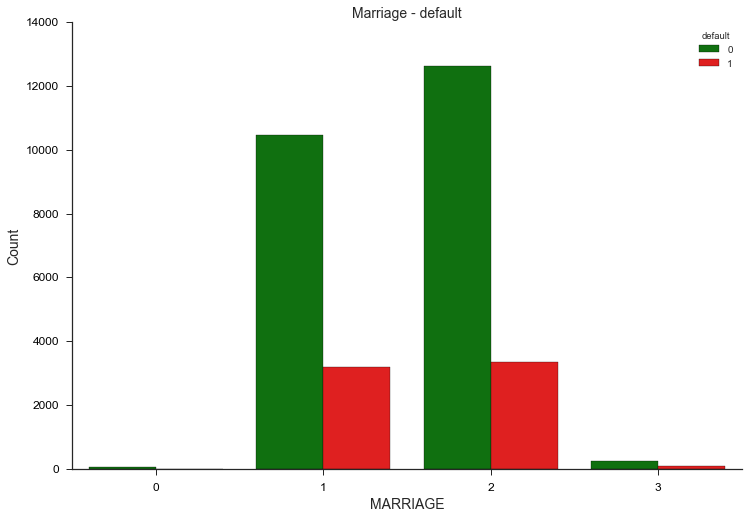

In [34]:
sns.set(style='ticks')

g = sns.countplot(x=data.MARRIAGE, hue=data.default, palette = sns.color_palette(['g', 'r']))
sns.despine()
g.figure.set_size_inches(12,8)
g.axes.set_title('Marriage - default', fontsize=14)
g.set_xlabel('MARRIAGE', size=14)
g.set_ylabel('Count', size=14)
g.tick_params(labelsize=12, labelcolor='black')

Аналогично предыдущему пункту здесь исследуется взаимосвязь двух категориальных признаков. 

$H_0\colon$ признаки MARRIAGE и default независимы или можно считать, что коэффициент Крамера равен нулю

$H_1\colon$ нулевая гипотеза неверна

In [35]:
observed_payment = np.bincount(data_payment.MARRIAGE)
observed_nonpayment = np.bincount(data_nonpayment.MARRIAGE)
observed_frequences = np.vstack((observed_payment, observed_nonpayment))

In [36]:
chi2, p, ddof, expected_frequences = stats.chi2_contingency(observed_frequences, correction=False)

Составим таблицу сопряженности для категориальных признаков MARRIAGE и default.

In [37]:
SimpleTable((observed_frequences[0, :], observed_frequences[1, :]), 
             headers = ["No answer", "Marriage", "Single", "NA"], 
             stubs=['payment', 'non-payment'], 
             title = 'Contingency table: Marriage - default')

,No answer,Marriage,Single,NA
payment,49,10453,12623,239
non-payment,5,3206,3341,84


Проверим условия применимости критерия хи-квадрат для таблиц сопряженности: 

* необходимо, чтобы выборки были достаточно большими: n >= 40 - очевидно, что выполняется

* необходимо, чтобы ожидаемое количество элементов в каждой ячейке таблицы было меньше 5 не более, чем в 20% ячеек

In [38]:
np.sum(expected_frequences < 5)

0

In [39]:
print "p-value: ", p

p-value:  8.82586245758e-08


Можно рассчитать коэффициент Крамера - меру взаимосвязи между двумя исследуемыми признаками MARRIAGE и default: 

In [40]:
n = 30000
K1 = 2
K2 = 4

V_cramer = np.sqrt(chi2 / (n * (min(K1, K2) - 1)))
print "V Cramer: ", V_cramer

V Cramer:  0.0344782036628


Достигаемый уровень значимости < 0.05, поэтому мы можем отклонить нулевую гипотезу и сделать вывод о том, что семейное положение и индикатор невозврата кредита связаны. 

## Пункт 5

Возраст (AGE): Относительно двух групп людей вернувших и не вернувших кредит проверьте следующие гипотезы: a) о равенстве медианных значений возрастов людей b) о равенстве распределений с помощью одного из подходящих непараметрических критериев проверки равенства средних. Значимы ли полученные результаты с практической точки зрения ?

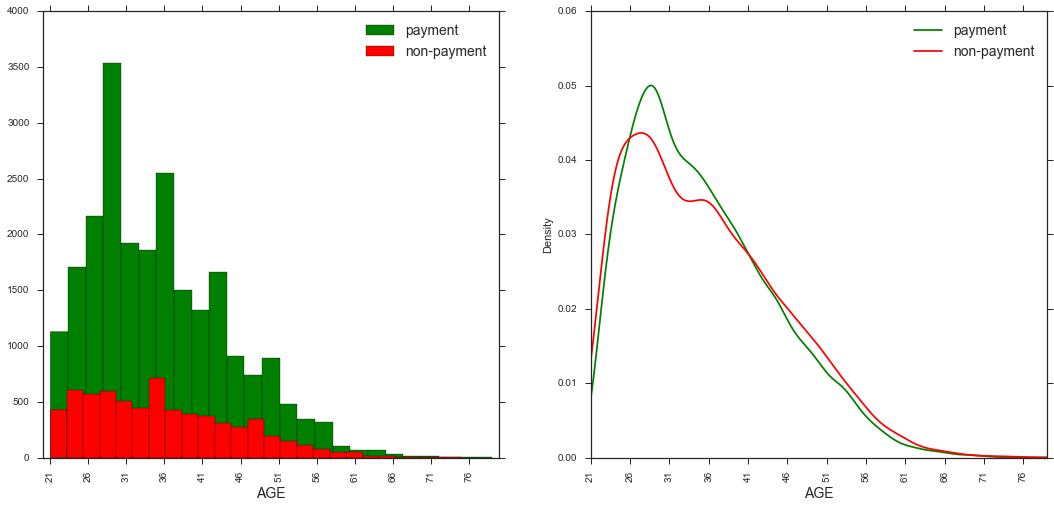

In [41]:
plt.figure(figsize = (18, 8))
plt.subplot(1, 2, 1)
plt.hist(data_payment.AGE, color='g', bins=25, label='payment')
plt.hist(data_nonpayment.AGE, color='r', bins=25, label='non-payment')
plt.legend(fontsize=14)
plt.xlabel('AGE', fontsize = 14)
plt.xticks(xrange(data.AGE.min(), data.AGE.max(), 5), rotation='vertical')

plt.subplot(1, 2, 2)
data_payment.AGE.plot(kind='density', color='g', label='payment')
data_nonpayment.AGE.plot(kind='density', color='r', label='non-payment')
plt.legend(fontsize=14)
plt.xlabel('AGE', fontsize = 14)
plt.xticks(xrange(data.AGE.min(), data.AGE.max(), 5), rotation='vertical')
plt.xlim(data.AGE.min(), data.AGE.max())
plt.show()

На графике видно, что распределения очень похожи по форме и параметрам. Скорее всего, между возрастом и признаком дефолта нет связи. 

a) Проверим равенство медианных значений кредитного лимита с помощью бутстрепа. 

$H_0\colon$ медианные значения равны

$H_1\colon$ меданные значение не равны

In [42]:
payment_median_scores = map(np.median, get_bootstrap_samples(data_payment.AGE.values, 1000))
non_payment_median_scores = map(np.median, get_bootstrap_samples(data_nonpayment.AGE.values, 1000))

Интервальная оценка медиан: 

In [43]:
print "95% confidence interval for the median AGE (default = 0):",  stat_intervals(payment_median_scores, 0.05)
print "95% confidence interval for the median AGE (default = 1):",  stat_intervals(non_payment_median_scores, 0.05)

95% confidence interval for the median AGE (default = 0): [ 34.  34.]
95% confidence interval for the median AGE (default = 1): [ 34.  35.]


Интервальная оценка разности медиан:

In [44]:
delta_median_scores = map(lambda scores: scores[0] - scores[1], zip(payment_median_scores, non_payment_median_scores))
print "95% confidence interval for the difference between medians AGE",  stat_intervals(delta_median_scores, 0.05)

95% confidence interval for the difference between medians AGE [-1.  0.]


Интервальные оценки медиан пересекаются и доверительный интервал для разности медиан содержит ноль, поэтому мы не можем отклонить гипотезу о равенстве медианных значений. 

b) Проверим гипотезу о равенстве распределений с помощью непараметрического перестановочного критерия. 

$H_0\colon F_{X_1}(x) = F_{X_2}(x)$

$H_1\colon F_{X_1}(x) = F_{X_2}(x + \Delta), \Delta\neq 0$ - если справедлива альтернативная гипотеза и между распределениями есть сдвиг, то средние значения выборок будут отличаться

Выборки независимые. 

In [45]:
print "p-value: %f" % permutation_test(data_payment.AGE, data_nonpayment.AGE, max_permutations=10000)

p-value: 0.017700


Достигаемый уровень значимости < 0.05, следовательно мы можем отклонить нулевую гипотезу о равенстве средних. 
Хотя выборки и оказались статистически различными, однако их медианы отличаются незначительно и ноль входит в доверительный интервал. С практической точки зрения, информативность признака AGE мала. Возможно, совместно с другими признаками возраст клиентов поможет улучшить скоринговую модель. 